# 1. Setup and get data

### 1.1 Install dependencies and setup

In [1]:
%pip install labelme tensorflow opencv-python matplotlib albumentations

Note: you may need to restart the kernel to use updated packages.


### 1.2 Collect images using OpenCv

In [2]:
import os
import time
import uuid
import cv2

In [3]:
DATA_PATH = '../data'
IMAGES_PATH = os.path.join(DATA_PATH, 'images')
number_images = 30

In [4]:
cap = cv2.VideoCapture(0)
for img_num in range(number_images):
    print(f'Collecting image #{img_num}')
    ret, frame = cap.read()
    img_name = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(img_name, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()
cv2.waitKey(1)
cap.release()

OUT OF LOOP


### 1.3 Annotate images with LabelMe

In [6]:
!labelme

[INFO   ] __init__:get_config:70 - Loading config file from: /Users/tomasmonaco/.labelmerc
2023-08-09 19:49:14.041 Python[91520:1587021] +[CATransaction synchronize] called within transaction
2023-08-09 19:49:28.835 Python[91520:1587021] +[CATransaction synchronize] called within transaction


# 2. Review dataset and build image loading fn

### 2.1 Import needed dependencies

In [4]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

2023-08-10 11:35:27.687277: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 2.2 Load images into TF data pipeline

In [5]:
images = tf.data.Dataset.list_files('../data/images/*.jpg', shuffle=False)

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: ../data/images/*.jpg'

In [ ]:
def load_image(img_path):
    byte_img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [ ]:
images = images.map(load_image)

In [ ]:
images.as_numpy_iterator().next()

array([[[54, 53, 33],
        [57, 56, 36],
        [57, 54, 37],
        ...,
        [85, 86, 78],
        [88, 90, 79],
        [87, 89, 78]],

       [[71, 70, 50],
        [57, 56, 36],
        [62, 59, 42],
        ...,
        [85, 86, 78],
        [84, 86, 75],
        [89, 91, 80]],

       [[64, 63, 45],
        [61, 60, 42],
        [67, 64, 49],
        ...,
        [88, 89, 81],
        [90, 91, 83],
        [87, 88, 80]],

       ...,

       [[70, 65, 35],
        [65, 61, 32],
        [67, 61, 35],
        ...,
        [70, 79, 74],
        [73, 79, 75],
        [71, 78, 71]],

       [[71, 64, 36],
        [62, 57, 28],
        [67, 60, 34],
        ...,
        [74, 85, 77],
        [69, 79, 71],
        [79, 89, 80]],

       [[68, 61, 33],
        [68, 61, 33],
        [68, 60, 37],
        ...,
        [63, 76, 67],
        [67, 77, 68],
        [68, 78, 69]]], dtype=uint8)

### 2.3 View raw images with matplotlib

In [ ]:
image_generator = images.batch(5).as_numpy_iterator()

In [ ]:
plot_images = image_generator.next()

NameError: name 'plot_images' is not defined

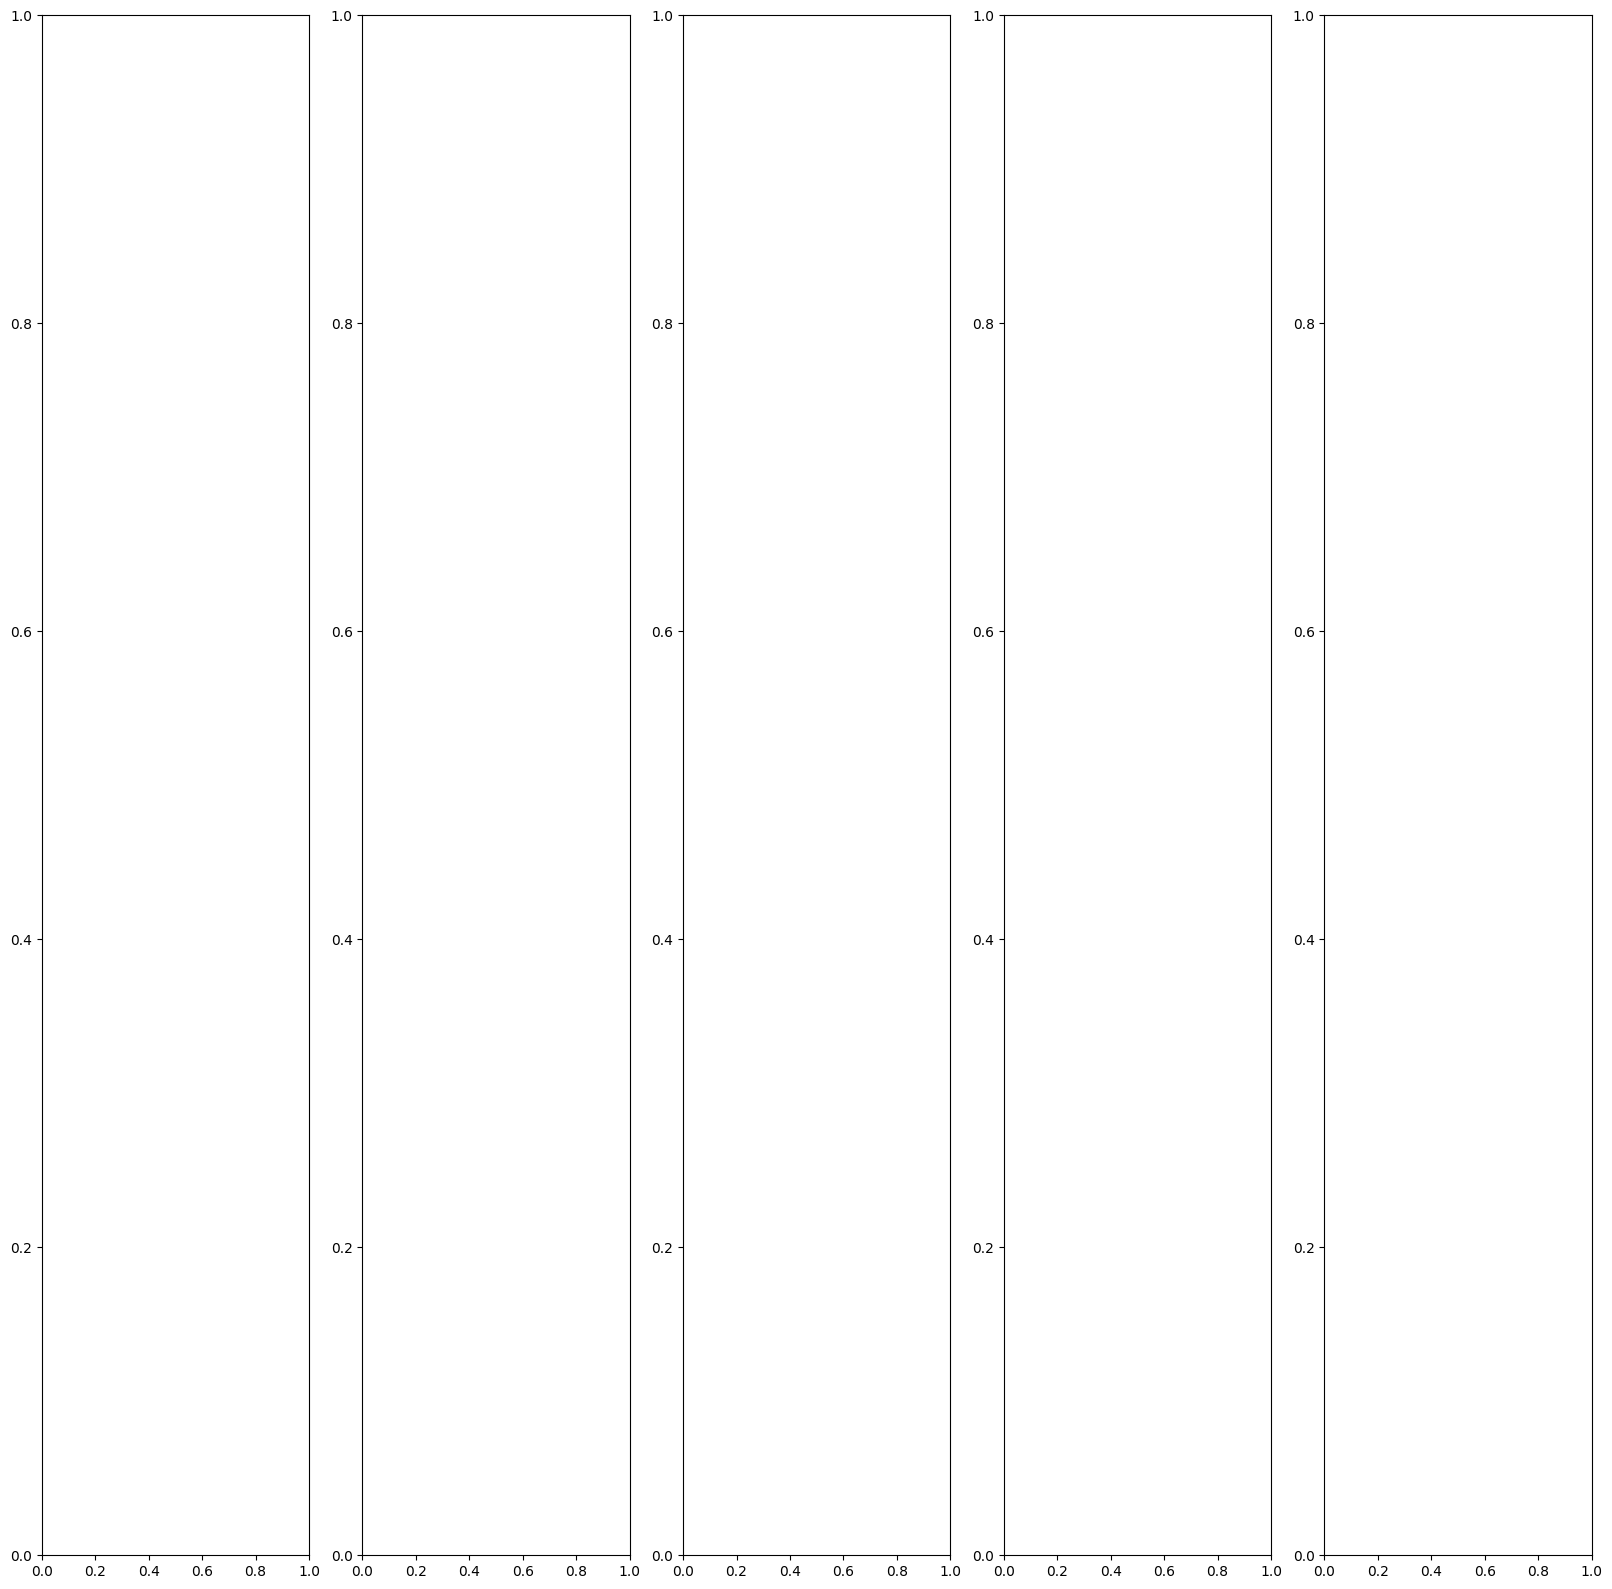

In [6]:
fig, ax = plt.subplots(ncols=5, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show

# 3. Partition augmented data

### 3.1 Manually split data into train/validation/test set - (try test_train from scikitlearn)

In [33]:
60 * .7 # train

42.0

In [32]:
60 * .15 # val

9.0

In [34]:
60 * .15  # test

9.0

### 3.2 Move the matching labels

In [42]:
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join(DATA_PATH, folder, 'images')):
        filename = file.split('.')[0] + '.json'
        existing_file_path = os.path.join(DATA_PATH, 'labels', filename)
        if os.path.exists(existing_file_path):
            new_file_path = os.path.join(DATA_PATH, folder, 'labels', filename)
            os.replace(existing_file_path, new_file_path)

# 4. Apply image augmentation using Albumentations

### 4.1 Setup albumentation's transform pipeline

In [7]:
import albumentations as alb

In [8]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450)
                        ,alb.HorizontalFlip(p=0.5)
                        ,alb.RandomBrightnessContrast(p=0.2)
                        ,alb.RandomGamma(p=0.2)
                        ,alb.RGBShift(p=0.2)
                        ,alb.VerticalFlip(p=0.5)]
                        ,bbox_params=alb.BboxParams(format='albumentations'
                                                     ,label_fields=['class_labels'])
                        )

### 4.2 Load and Test image with OpenCv and Json

In [9]:
img = cv2.imread(os.path.join(DATA_PATH, 'train', 'images', '8b2fe02a-36dc-11ee-9697-38f9d330045e.jpg'))

In [10]:
with open(os.path.join(DATA_PATH, 'train', 'labels', '8b2fe02a-36dc-11ee-9697-38f9d330045e.json'), 'r') as f:
    label = json.load(f)

In [12]:
img.shape

(720, 1280, 3)

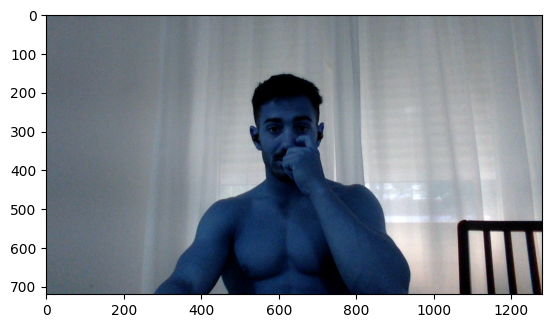

In [30]:
plt.imshow(img)

### 4.3 Extract coordinates and rescale to match new resolution

In [17]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [18]:
coords

[509.10112359550567, 144.83146067415726, 749.5505617977528, 457.19101123595505]

In [19]:
coords = list(np.divide(coords, [1280, 720, 1280, 720]))

In [20]:
coords

[0.3977352528089888,
 0.20115480649188508,
 0.5855863764044944,
 0.6349875156054932]

### 4.4 Apply augmentation and view results

In [21]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

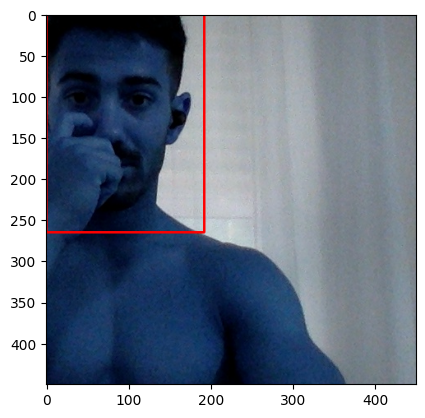

In [29]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [450, 450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450, 450]).astype(int)),
              (255, 0, 0),
              2
              )
plt.imshow(augmented['image'])